In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loading

In [301]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 535)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,thick_12.0,thick_15.0,thick_20.0,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,0,0,0,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0,0,0,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0,0,0,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0,0,0,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0,0,0,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [302]:
#dataset.columns.values

In [437]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 232
benddxf_deformation_length_01 --> 108
benddxf_deformation_length_02 --> 16
benddxf_deformation_length_03 --> 5
benddxf_deformation_length_04 --> 1
temp --> 4884
Done !


(4922, 537)

In [438]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('benddxf_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(4662, 537)

# cleaning to have at least min occurences

In [439]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

(4662, 537)

# Target definition

In [440]:
target = 'VALAJOUT'
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Outlier tracking - VAMAT

In [441]:
toplimit = .97 #We drop the top 3%
botlimit = .02 #we drop the bottom 2%

In [442]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
#dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

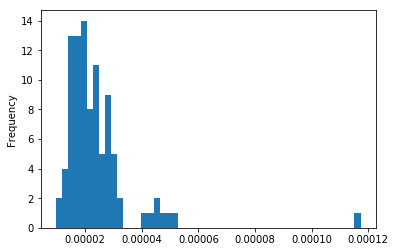

In [443]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [444]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.97            0.000048
3.0       0.02            0.000018
          0.97            0.000071
4.0       0.02            0.000023
          0.97            0.000105
5.0       0.02            0.000028
          0.97            0.000107
6.0       0.02            0.000033
          0.97            0.000149
8.0       0.02            0.000045
          0.97            0.000243
10.0      0.02            0.000062
          0.97            0.000281
12.0      0.02            0.000062
          0.97            0.000275
15.0      0.02            0.000084
          0.97            0.000290

In [445]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4662, 537)

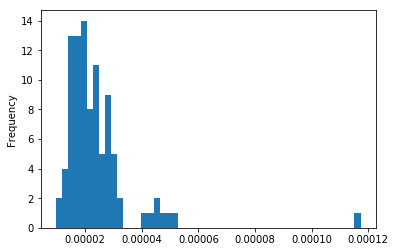

In [446]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

# Outlier tracking - VALAJOUT

In [447]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [448]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

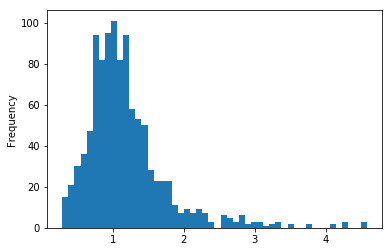

In [449]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [450]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.752600
                     0.95          4.014500
          1          0.02          0.835000
                     0.95          1.685000
          2          0.02          0.307467
                     0.95          1.897333
          3          0.02          0.646000
                     0.95          2.315000
          4          0.02          0.668000
                     0.95          1.792800
          5          0.02          0.257000
                     0.95          1.886333
          6          0.02          0.920000
                     0.95          0.920000
          7          0.02          0.838200
                     0.95          1.452500
          8          0.02          1.228822
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
          20         0.02          0.759048
                     0.95          0.759048
3.0       0          0.02          0.412400
                     0.95          4.014000
          1          0.02          0.444400
                     0.95          1.356000
          2          0.02          0.437067
                     0.95          1.596667
...                                     ...
10.0      0          0.02          0.708000
                     0.95          5.830000
          1          0.02          0.992800
                     0.95          3.485000
          2          0.02          0.659067
                     0.95          2.637833
          3          0.02          1.047700
                     0.95          2.940500
          4          0.02          1.674000
                     0.95          3.090400
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.652400
                     0.95          4.640000
          1          0.02          0.552300
                     0.95          2.243000
          2          0.02          0.716667
                     0.95          1.755333
          3          0.02          0.917800
                     0.95          1.048000
          4          0.02          1.814000
                     0.95          1.814000
15.0      0          0.02          0.807000
                     0.95          6.560000
          1          0.02          1.100000
                     0.95          1.902000
          2          0.02          0.853333
                     0.95          1.725000
          3          0.02          0.870000
                     0.95          1.252625

[144 rows x 1 columns]

In [451]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4301, 537)

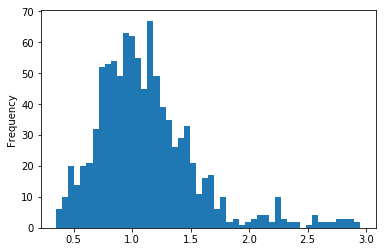

In [452]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

## Target review

In [453]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VALAJOUT
count,4301.000000
mean,2.709577
std,1.876309
min,0.290000
25%,1.470000
50%,2.310000
75%,3.440000
max,21.790000


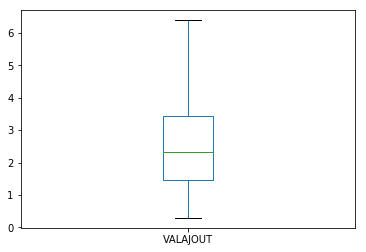

In [454]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [455]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',]

# 1 Bend as a float
limitedset.append('thickness')

# 2 Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

# 3 Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

# 4 Bends in groups
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

# 5 bends according DXF
limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

print(len(limitedset))
limitedset

273


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'benddxf_bend_radius_00',
 'benddxf_bend_angle_00',
 'benddxf_bend_direction_00',
 'benddxf_deformation_length_00',
 'benddxf_merged_bend_00',
 'benddxf_punch_length_00',
 'benddxf_bend_radius_01',
 'benddxf_bend_angle_01',
 'benddxf_bend_direction_01',
 'benddxf_deformation_length_01',
 'benddxf_merged_bend_01',
 'benddxf_punch_length_01',
 'benddxf_bend_radius_02',
 'benddxf_bend_angle_02',
 'benddxf_bend_direction_02',
 'benddxf_deformation_length_02',
 'benddxf_merged_bend_02',
 'benddxf_punch_length_02',
 'benddxf_bend_radius_03',
 'benddxf_bend_angle_03',
 'benddxf_bend_direction_03',
 'benddxf_deformation_length_03',
 'benddxf_merged_bend_03',
 'benddxf_punch_length_03',
 'benddxf_bend_radius_04',
 'benddxf_bend_angle_04'

In [456]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

print(X_train.shape, X_test.shape)

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

(3010, 537) (1291, 537)


# Blocs creation

In [457]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [458]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [459]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [460]:
#regressions
import lightgbm as lgb

gbm = lgb.LGBMRegressor(objective='regression',
                        #learning_rate=0.25,
                        n_estimators=200,
                        #max_depth=500,
                        #lambda_l1=0.1,
                        #min_child_samples=10,
                        random_state=0,
                       )

In [461]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [462]:
pipe = [('scaler', scaler), ('gbm', gbm)]
regpip = Pipeline(pipe)

In [463]:
regpip.fit(X_train[limitedset], y_train[target])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [464]:
param_grid = {
    'gbm__learning_rate': [0.125, 0.1, .075],
    #'gbm__n_estimators': [300, 400, 500],
    #'gbm__lambda_l1': np.logspace(-3,3,4),
    #'gbm__lambda_l2': np.logspace(-3,3,4),
    #'gbm__max_bin':[200, 150],
    #'gbm__num_leaves':[50, 100,150],
    #'gbm__max_depth':[-1, 500],
    'gbm__min_split_gain':[0,.1, 0.05],
    'gbm__min_data_in_leaf':[20,30,10],
    }

#MSE version
gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=5)

#MAPE version
#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [465]:
gridgbm.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0 
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0 
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0 
[CV]  gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0, score=-0.593984160529954, total=   3.1s
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0.1 
[CV]  gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0, score=-0.918628592543158, total=   3.3s
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0.1 
[CV]  gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0, score=-0.6458842502871855, total=   3.4s
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0.1 
[CV]  gbm__learning_rate=0.125, gbm__min_data_in_leaf=20, gbm__min_split_gain=0.1, score=

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   12.1s


[CV]  gbm__learning_rate=0.125, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.1, score=-0.9729709322814769, total=   1.8s
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05 
[CV]  gbm__learning_rate=0.125, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.1, score=-0.6567718439940896, total=   2.1s
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05 
[CV]  gbm__learning_rate=0.125, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.1, score=-0.6577557293636261, total=   1.8s
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05 
[CV]  gbm__learning_rate=0.125, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05, score=-0.9731500426574582, total=   2.3s
[CV] gbm__learning_rate=0.125, gbm__min_data_in_leaf=10, gbm__min_split_gain=0 
[CV]  gbm__learning_rate=0.125, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05, score=-0.6686187420180483, total=   2.0s
[CV] gbm__learning_rate=0.125, gbm__min_data_in_l

[CV] gbm__learning_rate=0.075, gbm__min_data_in_leaf=20, gbm__min_split_gain=0 
[CV]  gbm__learning_rate=0.1, gbm__min_data_in_leaf=10, gbm__min_split_gain=0.05, score=-0.6361231150023722, total=   2.8s
[CV] gbm__learning_rate=0.075, gbm__min_data_in_leaf=20, gbm__min_split_gain=0 
[CV]  gbm__learning_rate=0.075, gbm__min_data_in_leaf=20, gbm__min_split_gain=0, score=-0.8899691371458645, total=   3.2s
[CV] gbm__learning_rate=0.075, gbm__min_data_in_leaf=20, gbm__min_split_gain=0.1 
[CV]  gbm__learning_rate=0.075, gbm__min_data_in_leaf=20, gbm__min_split_gain=0, score=-0.5995726188388442, total=   3.3s
[CV] gbm__learning_rate=0.075, gbm__min_data_in_leaf=20, gbm__min_split_gain=0.1 
[CV]  gbm__learning_rate=0.075, gbm__min_data_in_leaf=20, gbm__min_split_gain=0, score=-0.6306692099133416, total=   3.9s
[CV] gbm__learning_rate=0.075, gbm__min_data_in_leaf=20, gbm__min_split_gain=0.1 
[CV]  gbm__learning_rate=0.075, gbm__min_data_in_leaf=20, gbm__min_split_gain=0.1, score=-0.5930436751946

[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:  1.0min


[CV]  gbm__learning_rate=0.075, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.1, score=-0.6335460746357945, total=   2.4s
[CV] gbm__learning_rate=0.075, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05 
[CV]  gbm__learning_rate=0.075, gbm__min_data_in_leaf=30, gbm__min_split_gain=0, score=-0.6594403155407407, total=   3.5s
[CV] gbm__learning_rate=0.075, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05 
[CV]  gbm__learning_rate=0.075, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.1, score=-0.6585180608986264, total=   2.7s
[CV] gbm__learning_rate=0.075, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05 
[CV]  gbm__learning_rate=0.075, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05, score=-0.9825978340512854, total=   3.1s
[CV] gbm__learning_rate=0.075, gbm__min_data_in_leaf=10, gbm__min_split_gain=0 
[CV]  gbm__learning_rate=0.075, gbm__min_data_in_leaf=30, gbm__min_split_gain=0.05, score=-0.6247409818981808, total=   2.8s
[CV] gbm__learning_rate=0.075, gbm__min_data_in_lea

[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__learning_rate': [0.125, 0.1, 0.075], 'gbm__min_split_gain': [0, 0.1, 0.05], 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [466]:
target

'VALAJOUT'

In [467]:
gridgbm.best_params_

{'gbm__learning_rate': 0.075,
 'gbm__min_data_in_leaf': 10,
 'gbm__min_split_gain': 0.1}

In [468]:
gridgbm.best_score_

-0.6370670714155401

In [469]:
mean_absolute_percentage_error(y_test[target], gridgbm.predict(X_test[limitedset]))

16.64748575528357

In [470]:
mean_squared_error(y_test[target], gridgbm.predict(X_test[limitedset]))

0.38636044792137997

In [471]:
mean_squared_error(y_train[target], gridgbm.predict(X_train[limitedset]))

0.11519686798711141

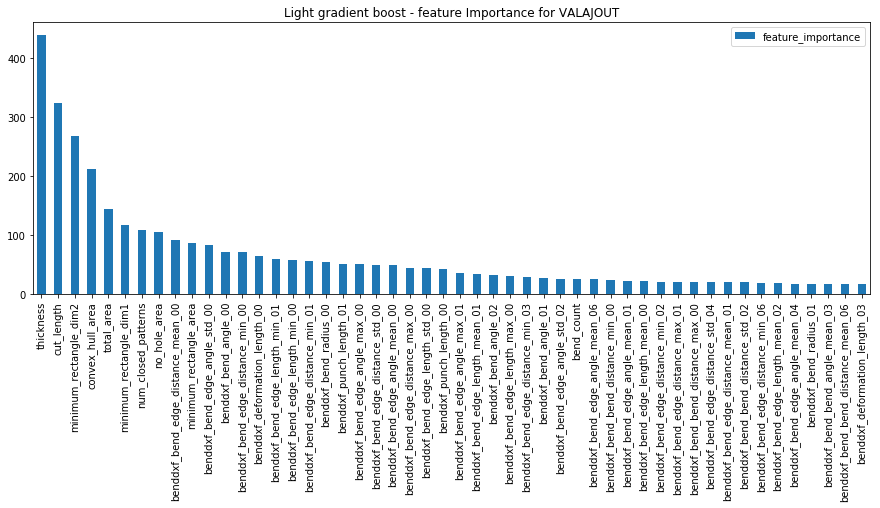

In [472]:
featimp = list(gridgbm.best_estimator_.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# Solution comparison

In [473]:
prediction_lgbm = gridgbm.predict(X_test[limitedset])

In [474]:
resultset = pd.DataFrame({'target': y_test[target],
                          'pred_lgbm':prediction_lgbm,
                            }, index=y_test.index)
resultset.head()

,pred_lgbm,target
COART,,
L6808420,1.710673,1.86
L2608270,1.392515,2.12
L8026710,1.480977,0.91
L3131180,1.518135,1.24
L3117310,4.962306,4.92


In [475]:
#Solution saving
resultset[['pred_lgbm']].to_csv(f'{target}_pred_lgbm.csv')


In [476]:
mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm'])

16.64748575528357

In [477]:
mean_squared_error(resultset['target'], resultset['pred_lgbm'])

0.38636044792137997

In [478]:
resultset['MSE_lgbm'] = (resultset['target']-resultset['pred_lgbm'])**2
resultset.head()

,pred_lgbm,target,MSE_lgbm
COART,,,
L6808420,1.710673,1.86,0.022299
L2608270,1.392515,2.12,0.529234
L8026710,1.480977,0.91,0.326014
L3131180,1.518135,1.24,0.077359
L3117310,4.962306,4.92,0.001790


In [479]:
resultset['MSE_lgbm'].mean()

0.3863604479213797

In [480]:
#
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_lgbm,target,MSE_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,...,thick_20.0,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L6808420,1.710673,1.86,0.022299,447.845245,1,0,4383.636230,5463.619141,133.259003,...,0,0.12,1.86,1.98,0.000004,0.000004,0.000005,1-2,0.000027,0.930
1,L2608270,1.392515,2.12,0.529234,897.396118,1,0,35987.578125,53316.320312,315.134613,...,0,1.96,2.12,4.08,0.000009,0.000007,0.000011,0,0.000054,2.120
2,L8026710,1.480977,0.91,0.326014,817.721985,1,0,41119.437500,41119.437500,230.360992,...,0,1.00,0.91,1.91,0.000006,0.000006,0.000006,1-2,0.000024,0.455
3,L3131180,1.518135,1.24,0.077359,835.963989,2,0,16047.501953,34990.789062,190.554184,...,0,2.00,1.24,3.24,0.000010,0.000007,0.000014,0,0.000111,1.240
4,L3117310,4.962306,4.92,0.001790,2777.277588,13,0,116923.531250,202040.062500,722.118347,...,0,11.21,4.92,16.13,0.000010,0.000007,0.000011,1-2,0.000090,2.460


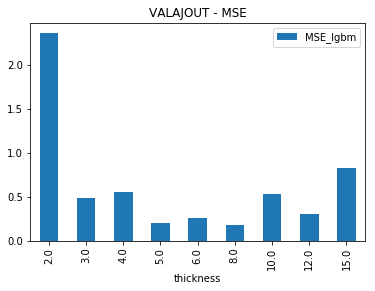

,MSE_lgbm
thickness,
2.0,2.353714
3.0,0.481671
4.0,0.546493
5.0,0.194503
6.0,0.260981
8.0,0.176183
10.0,0.524694
12.0,0.305410
15.0,0.819432


In [481]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_lgbm', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
df

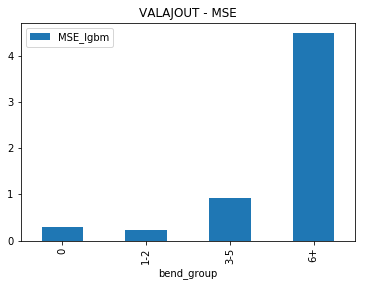

,MSE_lgbm
bend_group,
0,0.296593
1-2,0.217789
3-5,0.920646
6+,4.480537


In [483]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_lgbm', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
df

In [484]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm']), axis=1)
comparisonset['percent_error'] = ((comparisonset['target'] / comparisonset['pred_lgbm'])-1)*100
comparisonset[['target', 'pred_lgbm', 'MAPE_error']].head()

,target,pred_lgbm,MAPE_error
0,1.86,1.710673,8.028329
1,2.12,1.392515,34.315329
2,0.91,1.480977,62.744671
3,1.24,1.518135,22.430273
4,4.92,4.962306,0.859875


In [485]:
#MAPE
comparisonset['MAPE_error'].mean()

16.647485755283572

In [486]:
#If bends use this line
if target == 'VALAJOUT' or target == 'VALTOT':
    df = comparisonset[['MSE_lgbm', 'MAPE_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_lgbm', 'MAPE_error', 'thickness', 'COART']].groupby(['thickness'])

df.agg({'MSE_lgbm': ['mean', 'max'], 'MAPE_error': ['mean', 'max'],'COART':['count'] })

MSE_lgbm            MAPE_error             COART
                           mean        max       mean         max count
thickness bend_group                                                   
2.0       0            0.796540   0.796540  51.888994   51.888994     1
          1-2          0.227110   1.780677  20.924087  134.789908    10
          3-5          1.933616   6.440173  19.316128   42.795102    13
          6+          16.495962  31.121631  40.386736   74.086008     2
3.0       0            0.391066   2.822699  30.270214  195.508135    24
          1-2          0.142583   1.274740  12.527447   74.771115    40
          3-5          0.722264   7.223821  15.220441   61.054337    36
          6+           4.020036   7.206159  25.666854   45.731330     2
4.0       0            0.085422   0.868511  27.027560   97.015153    26
          1-2          0.152482   2.115491  15.979376  101.549857   103
          3-5          1.763800  14.839829  25.323158  100.960692    36
          6+           9.294461   9.294461  46.975067   46.975067     1
5.0       0            0.206896   2.455599  37.522172  184.239964    50
          1-2          0.159062   1.502109  12.889727   83.042691    89
          3-5          0.188103   1.425769   7.949693   27.952128    30
          6+           0.739822   3.540990   7.032474   26.729430     5
6.0       0            0.085628   1.539317  18.352029  173.978437   110
          1-2          0.275352   5.340367  15.667702  128.703194   148
          3-5          0.501181   2.749760  15.066757   89.152691    22
          6+           2.636499   7.271124  11.607377   29.387166     5
8.0       0            0.157950   5.715269  16.203690  103.550364   133
          1-2          0.153675   1.328911  10.120985   60.429568   101
          3-5          0.437203   3.734665   8.670733   29.504247    18
10.0      0            0.548166   8.567718  16.228341   70.787739    94
          1-2          0.411248   9.491129  10.855983   68.870961    61
          3-5          2.096005   5.443556  17.794716   41.812597     3
12.0      0            0.332603   8.995459  16.507106   70.239885    61
          1-2          0.230010   0.849531  15.812659   76.814930    22
15.0      0            0.844438   6.909535  18.379407   50.051587    42
          1-2          0.469357   0.836987  13.215923   19.975326     3

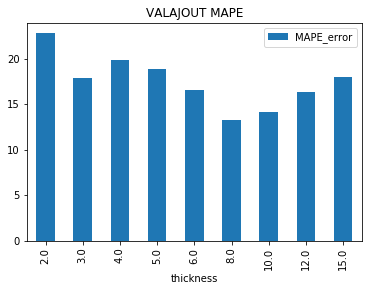

,MAPE_error
thickness,
2.0,22.808192
3.0,17.910320
4.0,19.922898
5.0,18.947974
6.0,16.586136
8.0,13.227712
10.0,14.183944
12.0,16.323035
15.0,18.035175


In [487]:
df = comparisonset[['MAPE_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
df

In [488]:
df = comparisonset[['COART', 'thickness']]
df.groupby('thickness').count()

,COART
thickness,
2.0,26
3.0,102
4.0,166
5.0,174
6.0,285
8.0,252
10.0,158
12.0,83
15.0,45


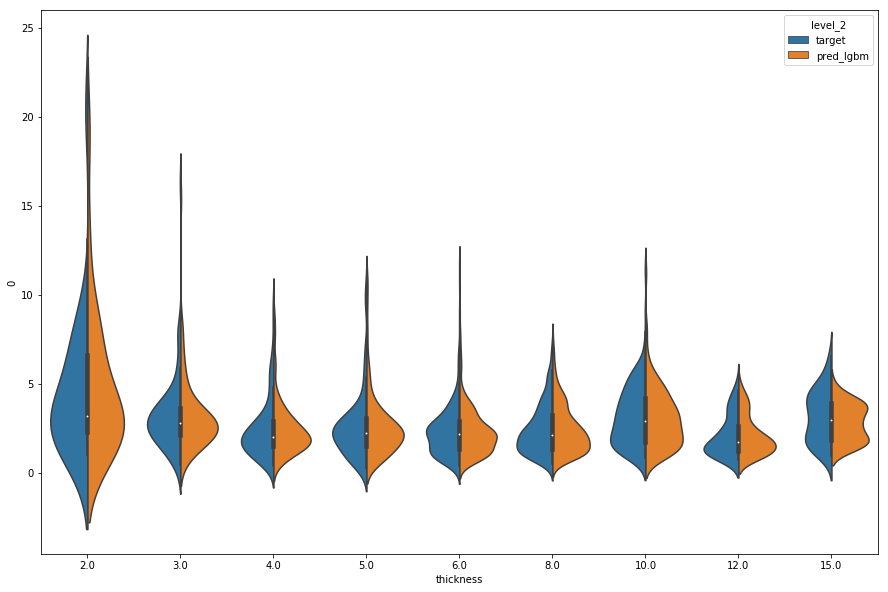

In [489]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)

plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


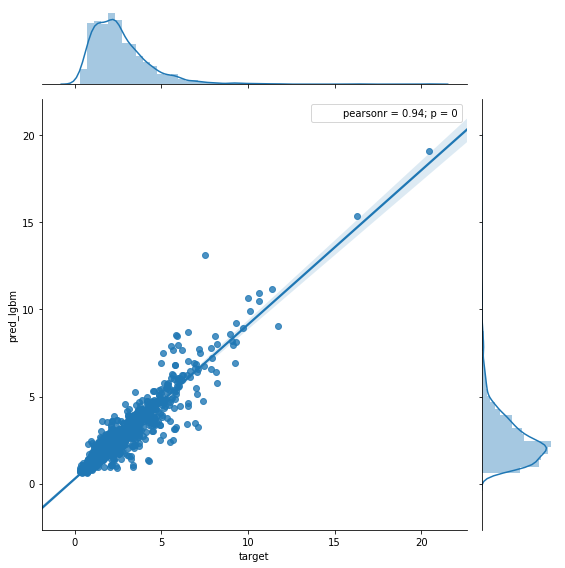

In [490]:
sns.jointplot(x='target', y='pred_lgbm', data=comparisonset, kind='reg', size=8)

In [354]:
X_test.shape

(1477, 537)

In [355]:
df = comparisonset[['MSE_lgbm', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_lgbm'].nlargest(5)

worst.to_csv('../Y3 - Sample data/Z3 - outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L6020240    16.928475
           L6019240    14.991541
           L6010240    13.057512
           L8045481     4.112786
           L3124070     2.249850
3.0        L3103500    18.691030
           L3100100    14.129929
           L8051761     6.780703
           L3103530     5.030426
           L7008401     3.631003
4.0        L8818570    87.743887
           L6703411    18.646222
           L6704740    15.615747
           L6704071    12.136077
           L6021770    10.533964
5.0        L3100190     8.452433
           L8022330     6.878429
           L7065630     6.679619
           L8828280     4.897259
           L7051090     3.388667
6.0        L2611660    12.436462
           L8039420     8.284734
           L3107180     6.879145
           L7022810     5.811641
           L7035730     4.036011
8.0        L8835850    20.420024
           L8415650     7.779139
           L2512260     7.409624
           L3108020     5.567960
           L2513180    

In [356]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 8]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 10000]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

,82,359,487,894,961,1033,1150,1475
COART,L8835850,L2520480,L2513180,L6014830,L3108012,L2603300,L2512260,L2509970
pred_lgbm,13.3711,4.42838,4.39565,5.43734,5.65011,3.85071,4.16794,4.76465
target,17.89,6.64,6.64,5.31,4.12,3.85,6.89,4.5
MSE_lgbm,20.42,4.89127,5.03713,0.0162162,2.34123,5.04892e-07,7.40962,0.0700419
cut_length,6989.19,1583.34,1583.34,1866.36,1148.17,812.513,1143.75,1323.45
num_closed_patterns,19,6,6,5,8,3,3,4
num_open_patterns,0,0,0,0,0,0,0,0
total_area,196112,84344.4,84344.5,89571.9,26845,16131,36513.2,43451.9
minimum_rectangle_area,626653,93314.5,93314.5,128709,45057,31559.5,36881.9,53812.3
minimum_rectangle_dim1,1322.67,444.355,444.355,495.035,326.242,233.774,444.36,489.203


In [357]:
dataset.loc[['L8835850']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

COART,L8835850
cut_length,6989.19
num_closed_patterns,19
num_open_patterns,0
total_area,196112
minimum_rectangle_area,626653
minimum_rectangle_dim1,1322.67
minimum_rectangle_dim2,473.779
convex_hull_area,530068
no_hole_area,221461
thickness,8


# Summing solution :  
VALTOT = VAMAT + VALAJOUT

In [273]:
resultset.head()

,pred_lgbm,target,MSE_lgbm
COART,,,
L7032081,4.332405,3.81,0.272907
L8030540,10.700101,12.05,1.822226
L3103740,5.951177,6.22,0.072266
L6704900,1.224130,1.21,0.000200
L6810110,0.794695,0.89,0.009083


In [274]:
VAMAT = pd.read_csv('VAMAT_pred_lgbm.csv')
VAMAT.columns = ['COART', 'VAMAT_pred']
VALAJOUT = pd.read_csv('VALAJOUT_pred_lgbm.csv')
VALAJOUT.columns = ['COART', 'VALAJOUT_pred']
print(VAMAT.shape, VALAJOUT.shape)

(1526, 2) (1477, 2)


In [275]:
sumset = pd.merge(resultset.reset_index(), VAMAT, on='COART', how='inner')
sumset = pd.merge(sumset, VALAJOUT, on='COART', how='inner')

sumset.shape

(136, 6)

In [276]:
sumset['VALTOT_sum'] = sumset['VAMAT_pred'] + sumset['VALAJOUT_pred']
sumset.head()

,COART,pred_lgbm,target,MSE_lgbm,VAMAT_pred,VALAJOUT_pred,VALTOT_sum
0,L6704900,1.224130,1.21,0.000200,0.315361,0.820922,1.136283
1,L8055490,3.609483,2.89,0.517656,1.306560,1.916505,3.223065
2,L8043180,10.478694,11.35,0.759174,7.431087,3.879183,11.310270
3,L2507570,10.841368,11.38,0.290125,6.150464,3.801295,9.951760
4,L2509970,7.524805,7.10,0.180459,3.061411,4.694543,7.755954


In [277]:
mean_absolute_percentage_error(sumset['target'], sumset['VALTOT_sum'])

13.36666215205417

In [278]:
mean_squared_error(sumset['target'], sumset['VALTOT_sum'])

1.9271738152577798

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


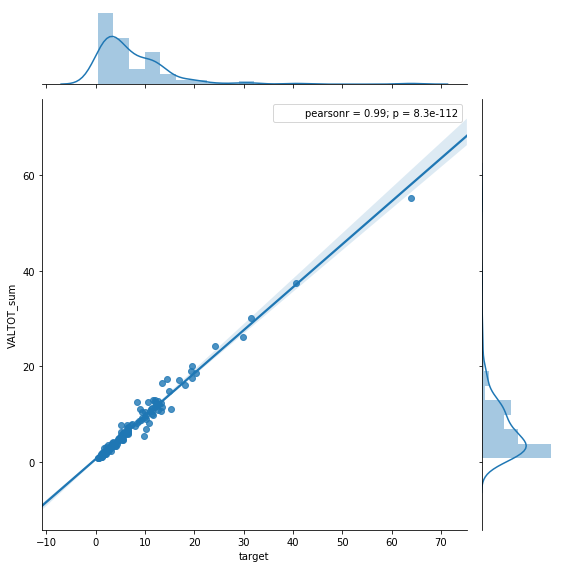

In [279]:
sns.jointplot(x='target', y='VALTOT_sum', data=sumset, kind='reg', size=8)

# Hyper Opt

In [ ]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

https://github.com/hyperopt/hyperopt/wiki/FMin

In [ ]:

scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(X_train[limitedset])
Xte_scaled = scaler.transform(X_test[limitedset])

In [ ]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'max_depth': int(params['num_leaves']),
        'min_split_gain': params['min_split_gain'],
        'reg_alpha': params['reg_alpha'],
        #'reg_lambda': params['reg_lambda'],
        'min_child_weight': int(params['min_child_weight']),
        'learning_rate':params['learning_rate'],
        
    }
    
    clf = lgb.LGBMRegressor(objective='regression',
        n_estimators=500,
        **params
    )
    
    score = cross_val_score(clf, Xtr_scaled, y_train[target], scoring='neg_mean_squared_error', cv=3).mean()
    print("MSE {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'max_depth': hp.uniform('max_depth', 1000, 1500),
    'min_split_gain': hp.uniform('min_split_gain', 0, 10),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    #'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'min_child_weight': hp.uniform('min_child_weight', 0, 20),
    'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

In [ ]:
print("Hyperopt estimated optimum {}".format(best))

In [ ]:
gbm = lgb.LGBMRegressor(objective='regression',
                        learning_rate=0.1,
                        n_estimators=500,
                        max_depth=1100,
                        lambda_l1=.4,
                        #lambda_l2=4.58,
                        colsample_bytree=0.06,
                        num_leaves=100,
                        min_split_gain=7,
                        min_child_weight=13,
                        random_state=0,
                       )
pipe = [('scaler', scaler), ('gbm', gbm)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train[target])

In [ ]:
mean_squared_error(y_test[target], regpip.predict(X_test[limitedset]))

In [ ]:
mean_squared_error(y_train[target], regpip.predict(X_train[limitedset]))

In [ ]:
regpip.named_steps['gbm']